In [9]:
%%capture
import sys; sys.path.append('../../..')

# Requires alpaca_trade_api backtrader matplotlib==3.2.2 plotly quantstats ta-lib (also requires talib C install)
from alpaca_trade_api.rest import REST, TimeFrame, TimeFrameUnit
import backtrader as bt
import matplotlib as mpl
import pytz
import datetime
from functools import lru_cache

import datetime

mpl.rcParams['figure.dpi'] = 250


API_KEY: str = ""
SECRET_KEY: str = ""
for l in open('../../../paper.env'):
    if l.startswith("APCA_API_KEY_ID="):
        API_KEY = l.split("=")[1].strip()
    elif l.startswith("APCA_API_SECRET_KEY="):
        SECRET_KEY = l.split("=")[1].strip()

assert API_KEY
assert SECRET_KEY

rest_api = REST(API_KEY, SECRET_KEY, 'https://paper-api.alpaca.markets')



@lru_cache()
def get_pandas_data(symbol, timeframe, start, end):
  alpaca_data = rest_api.get_bars(symbol, timeframe, start, end, adjustment='all').df
  alpaca_data.index = alpaca_data.index.tz_convert("America/New_York")

  if timeframe != TimeFrame.Day:
    alpaca_data = alpaca_data.between_time(datetime.time(9, 30), datetime.time(16, 0), include_end=False)

  return alpaca_data


def run_backtest(strategy, symbol: str, start: datetime.date, end: datetime.date, params, cash: float):
  cerebro = bt.Cerebro(stdstats=True)
  cerebro.broker.setcash(cash)
  cerebro.addstrategy(strategy, **params)
  cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
  cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='tradeanalyzer')
  cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name="annualreturn")
  cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')

  data1m = get_pandas_data(symbol, TimeFrame.Minute, start, end)
  feed1 = bt.feeds.PandasData(dataname=data1m, name=f"{symbol}-1m", tz=pytz.timezone('US/Eastern'))
  cerebro.adddata(feed1)

  # NOTE: -31 days so we have room for daily indicator warmup period for indicators
  datad = get_pandas_data(symbol, TimeFrame.Day, start - datetime.timedelta(days=31), end)
  feed2 = bt.feeds.PandasData(dataname=datad, name=f"{symbol}-d", tz=pytz.timezone('US/Eastern'))
  cerebro.adddata(feed2)

  results = cerebro.run()

  cerebro.plot(iplot=True)

  strat = results[0]
  return strat

def get_roi(strategy):
  annual_returns = strategy.analyzers.annualreturn.get_analysis()
  r = 1
  for ret in annual_returns.values():
    r *= 1 + ret
  r -= 1
  return r

def get_max_drawdown(strategy):
  return strategy.analyzers.drawdown.get_analysis()['max']['drawdown']/100



In [10]:
symbol = 'NRGU'
start = datetime.date(2021, 10, 1)
end = datetime.date(2022, 5, 31)
cash = 5000

In [11]:
class MyStrategy(bt.Strategy):
    params = dict(
      atr_d_period=20,
      take_profit_levels_up=1,
      stop_loss_levels_down=1,
      level_size_atr_multiplier=1,
      verbose=True,
    )

    def __init__(self):
      self.occupations = {}
      self.atr = bt.ind.ATR(self.data1, period=self.p.atr_d_period)
      # NOTE on data1: [0] is daily bar for current day (which is a premonition), so always -1 it to get yesterday's values
    
    def log(self, *message):
      if self.p.verbose:
        print(self.data.datetime.datetime(0), *message)

    def next(self):
      now = self.data.datetime.datetime(0)
      level_size = self.atr.atr[-1] * self.p.level_size_atr_multiplier
      level_to_occupy = self.data.close[0] // level_size

      # bad data
      if level_to_occupy > 40:
        return

      if level_to_occupy in self.occupations:
        # if already entered
        if self.occupations[level_to_occupy]['size'] != 0:
          return

        # if recently attempted entry
        if self.occupations[level_to_occupy]['size'] < 1 and now - self.occupations[level_to_occupy]['time'] < datetime.timedelta(minutes=10):
          return
        
        self.log(f"evacuating {level_to_occupy} due to lack of fill")
        # we entered a while back and still have not been filled, let's exit
        self.occupations[level_to_occupy]['order'].cancel()
        del self.occupations[level_to_occupy]
      
      self.occupations[level_to_occupy] = {
        'size': 0,
        'time': now,
      }
      size = 1000 // self.data.close[0]
      orders = self.buy_bracket(size=size,
        limitprice=self.data.close[0] + (self.p.take_profit_levels_up*level_size),
        stopprice=self.data.close[0] - (self.p.stop_loss_levels_down*level_size),
        tradeid=level_to_occupy)
      self.occupations[level_to_occupy]['order'] = orders[0]

    def notify_order(self, order: bt.Order):
      if order.status not in (bt.Order.Completed, bt.Order.Partial):
        return
      
      self.occupations[order.tradeid]['size'] += order.executed.size
      if 'order' in self.occupations[order.tradeid]:
        del self.occupations[order.tradeid]['order']
      if 'time' in self.occupations[order.tradeid]:
        del self.occupations[order.tradeid]['time']
      
      if self.occupations[order.tradeid]['size'] < 1:
        del self.occupations[order.tradeid]

      self.log(self.occupations)


<IPython.core.display.Javascript object>

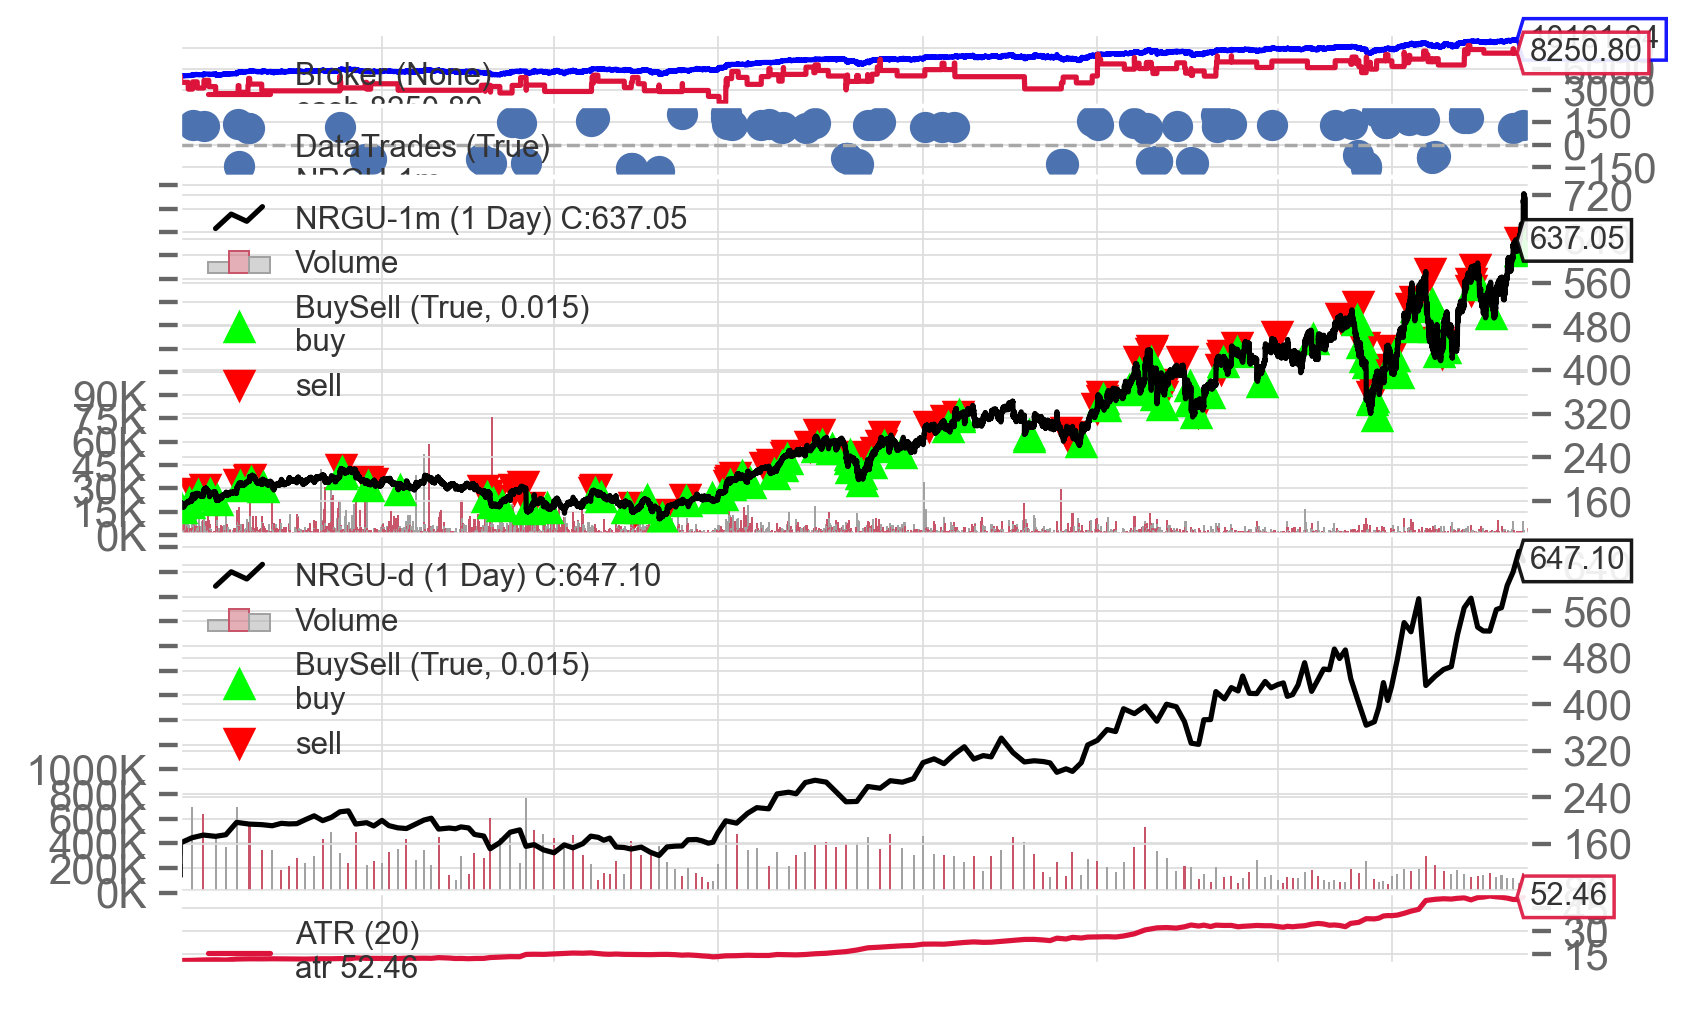

In [12]:
strategy = run_backtest(MyStrategy, symbol, start, end,
  {'atr_d_period': 20,
 'take_profit_levels_up': 2,
 'stop_loss_levels_down': 2,
 'level_size_atr_multiplier': 1,
 'verbose': False}
  , cash
)

# Detail

In [13]:
annual_returns = strategy.analyzers.annualreturn.get_analysis()
analysis = strategy.analyzers.tradeanalyzer.get_analysis()
print(strategy.p.__dict__)
print(f"ROI     : {get_roi(strategy):.1%}")
print(f"Drawdown: {strategy.analyzers.drawdown.get_analysis()['max']['drawdown']/100:.1%}")
print(f"Average : {analysis['total']['total']} trades @ {analysis['pnl']['gross']['average']:.2f}")
print(f"Winners : {(analysis['won']['total'] / analysis['total']['total']):.1%} @ {analysis['won']['pnl']['average']:.2f}")
print(f"Losers  : {(analysis['lost']['total'] / analysis['total']['total']):.1%} @ {analysis['lost']['pnl']['average']:.2f}")

{'atr_d_period': 20, 'take_profit_levels_up': 2, 'stop_loss_levels_down': 2, 'level_size_atr_multiplier': 1, 'verbose': False}
ROI     : 101.4%
Drawdown: 13.4%
Average : 92 trades @ 58.94
Winners : 65.2% @ 146.05
Losers  : 31.5% @ -121.27


In [14]:
import quantstats
portfolio_stats = strategy.analyzers.getbyname('PyFolio')
returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
returns.index = returns.index.tz_convert(None)
quantstats.reports.basic(returns)

                    Strategy
------------------  ----------
Start Period        2021-08-31
End Period          2022-05-31
Risk-Free Rate      0.0%
Time in Market      89.0%

Cumulative Return   103.24%
CAGR﹪              158.11%

Sharpe              3.18
Sortino             5.54
Sortino/√2          3.92
Omega               1.79

Max Drawdown        -12.57%
Longest DD Days     41

Gain/Pain Ratio     0.79
Gain/Pain (1M)      38.05

Payoff Ratio        1.23
Profit Factor       1.79
Common Sense Ratio  2.38
CPC Index           1.31
Tail Ratio          1.33
Outlier Win Ratio   4.28
Outlier Loss Ratio  3.18

MTD                 16.05%
3M                  33.47%
6M                  82.47%
YTD                 73.58%
1Y                  103.24%
3Y (ann.)           158.11%
5Y (ann.)           158.11%
10Y (ann.)          158.11%
All-time (ann.)     158.11%

Avg. Drawdown       -2.83%
Avg. Drawdown Days  7
Recovery Factor     8.21
Ulcer Index         0.03
Serenity Index      10.5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
from src.results import metadata, from_backtest
from src import types

transactions.index = transactions.index.tz_convert("America/New_York")
transactions['time'] = transactions.index

from_backtest.write_results("dynamic-rungs", [types.FilledOrder(intention=None, symbol=t['symbol'], quantity=t['amount'], price=t['price'], datetime=t['time'].to_pydatetime()) for t in transactions.to_dict('records')], metadata.Metadata(commit_id="", last_updated=datetime.datetime.now()))

# Optimize

In [16]:
gridsearch = dict(
    atr_d_period=[5, 14, 20],
    take_profit_levels_up=[1, 2],
    stop_loss_levels_down=[1, 2],
    level_size_atr_multiplier=[1, 0.5, 1.5, 2],
    verbose=[False],
)

time_per = datetime.timedelta(seconds=14)

choices = 1
for l in gridsearch.values():
  choices *= len(l)

estimated_time = time_per * choices
print(f"Estimated time (@ {time_per}, {choices}): {estimated_time}")
start_time = datetime.datetime.now()
print(f"(ending at {start_time + (time_per * choices)})")
print("=" * 80)

cerebro = bt.Cerebro(stdstats=True, maxcpus=1)  # inside of VS Code editor, this does not go well
cerebro.broker.setcash(cash)
cerebro.optstrategy(MyStrategy, **gridsearch)
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='tradeanalyzer')
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name="annualreturn")

data1m = get_pandas_data(symbol, TimeFrame.Minute, start, end)
feed1 = bt.feeds.PandasData(dataname=data1m, name=f"{symbol}-1m", tz=pytz.timezone('US/Eastern'))
cerebro.adddata(feed1)

# NOTE: -31 days so we have room for daily indicator warmup period for indicators
datad = get_pandas_data(symbol, TimeFrame.Day, start - datetime.timedelta(days=31), end)
feed2 = bt.feeds.PandasData(dataname=datad, name=f"{symbol}-d", tz=pytz.timezone('US/Eastern'))
cerebro.adddata(feed2)

runs = cerebro.run()
backtest_results = [results[0] for results in runs]


end_time = datetime.datetime.now()
print(f"Done. Took {end_time - start_time}")
print(f"time per: {(end_time - start_time) / choices}")

Estimated time (@ 0:00:14, 48): 0:11:12
(ending at 2022-06-09 11:15:57.862292)
Done. Took 0:11:20.230333
time per: 0:00:14.171465


In [17]:
import pandas as pd

def build_row(strategy):
  analysis = strategy.analyzers.tradeanalyzer.get_analysis()
  row = {
    'roi': get_roi(strategy),
    'drawdown': get_max_drawdown(strategy),
    'trades': analysis['total']['total'],
    'average_$': analysis['pnl']['gross']['average'],
    'win_rate': analysis['won']['total'] / analysis['total']['total'],
    'average_win_$': analysis['won']['pnl']['average'],
    'average_loss_$': analysis['lost']['pnl']['average'],
    'params': strategy.p.__dict__
  }
  row.update(strategy.p.__dict__)
  return row
results = pd.DataFrame([build_row(strategy) for strategy in sorted(backtest_results, key=get_roi, reverse=True) if strategy.analyzers.tradeanalyzer.get_analysis()['total']['total'] > 0])

In [24]:
results.sort_values('roi').tail()

,roi,drawdown,trades,average_$,win_rate,average_win_$,average_loss_$,params,atr_d_period,take_profit_levels_up,stop_loss_levels_down,level_size_atr_multiplier,verbose
4,1.047993,0.281967,309,17.594380,0.566343,83.006927,-69.126800,"{'atr_d_period': 5, 'take_profit_levels_up': 2...",5,2,2,0.5,False
3,1.134803,0.253809,48,127.460551,0.729167,219.146063,-164.266079,"{'atr_d_period': 14, 'take_profit_levels_up': ...",14,2,2,1.5,False
2,1.222073,0.265056,28,241.988191,0.821429,302.492738,-221.880000,"{'atr_d_period': 14, 'take_profit_levels_up': ...",14,2,2,2.0,False
1,1.242993,0.248720,32,218.529903,0.687500,317.479499,-216.848318,"{'atr_d_period': 5, 'take_profit_levels_up': 2...",5,2,2,2.0,False
0,1.289087,0.329637,45,153.473252,0.755556,247.648951,-202.301613,"{'atr_d_period': 5, 'take_profit_levels_up': 2...",5,2,2,1.5,False


In [19]:
results.sort_values('drawdown').head()

,roi,drawdown,trades,average_$,win_rate,average_win_$,average_loss_$,params,atr_d_period,take_profit_levels_up,stop_loss_levels_down,level_size_atr_multiplier,verbose
31,0.744108,0.107947,206,19.128983,0.592233,78.052349,-67.481265,"{'atr_d_period': 14, 'take_profit_levels_up': ...",14,1,1,1.0,False
33,0.719622,0.109619,105,37.041778,0.628571,111.271124,-95.367325,"{'atr_d_period': 14, 'take_profit_levels_up': ...",14,1,1,1.5,False
21,0.856742,0.119606,77,59.641664,0.792208,111.204340,-165.024282,"{'atr_d_period': 20, 'take_profit_levels_up': ...",20,1,2,1.5,False
42,0.603823,0.120232,109,29.880873,0.596330,110.326415,-94.618180,"{'atr_d_period': 20, 'take_profit_levels_up': ...",20,1,1,1.5,False
23,0.832377,0.120456,80,56.206451,0.787500,109.342931,-166.966764,"{'atr_d_period': 14, 'take_profit_levels_up': ...",14,1,2,1.5,False


<IPython.core.display.Javascript object>

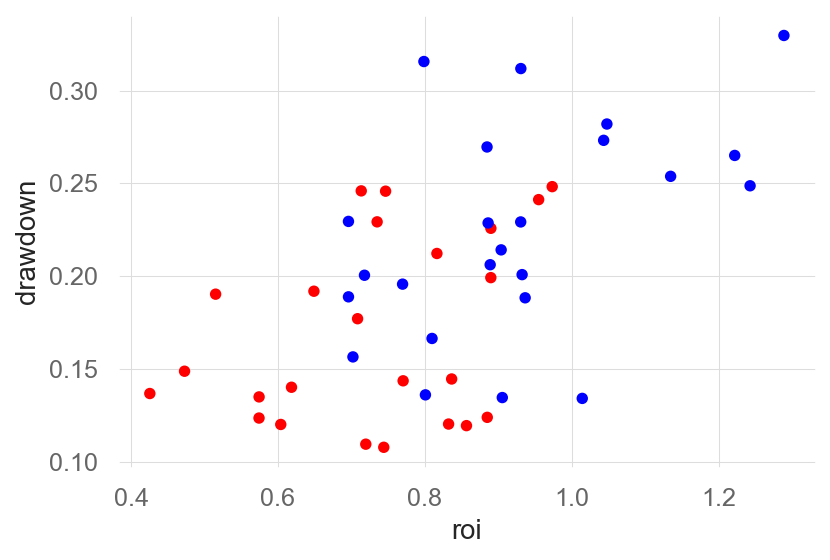

In [20]:
mpl.rcParams['figure.dpi'] = 150
results.plot(x='roi', y='drawdown', kind='scatter', c=results.take_profit_levels_up.map({1: 'red', 2: 'blue'}))

<IPython.core.display.Javascript object>

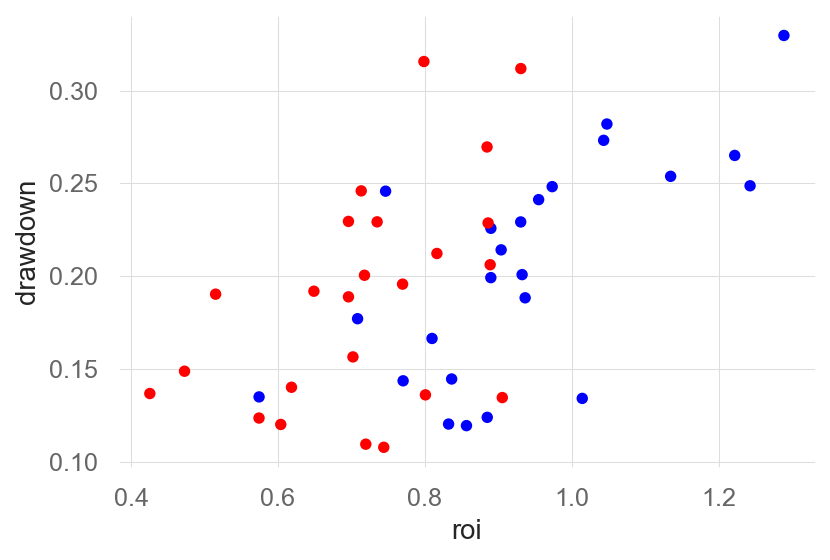

In [21]:
results.plot(x='roi', y='drawdown', kind='scatter', c=results.stop_loss_levels_down.map({1: 'red', 2: 'blue'}))

<IPython.core.display.Javascript object>

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


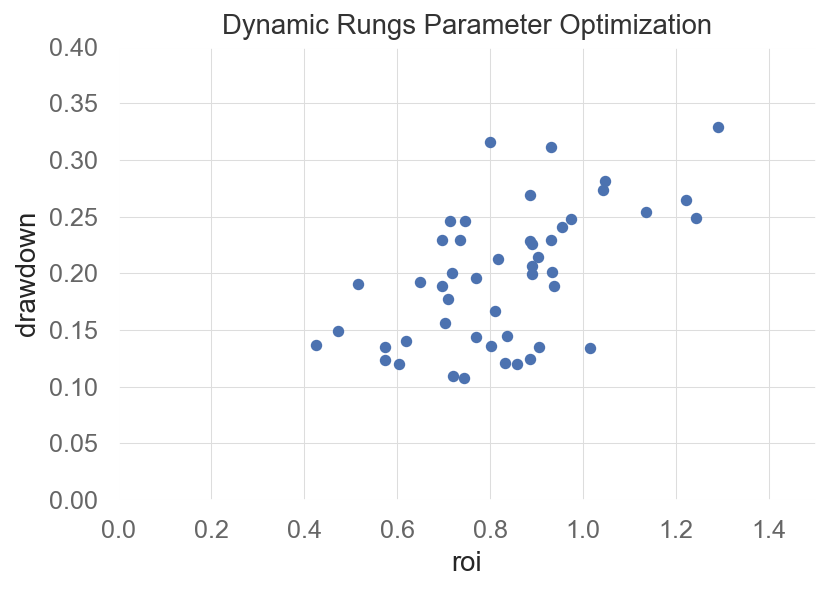

In [25]:
results.plot(x='roi', y='drawdown', kind='scatter', xlim=(0, 1.5), ylim=(0, .4), title="Dynamic Rungs Parameter Optimization")